In [20]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
---
---
## Get information about the Last Visit Delta registered for each patient
### This information will be used to check Valid Uncensored and Censored

In [21]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022/')

data_files = [
    ['PROACT_ALSFRS'    , 'ALSFRS_Delta'],
    ['PROACT_FVC'       , 'Forced_Vital_Capacity_Delta'],
    ['PROACT_DEATHDATA' , 'Death_Days'],
    ['PROACT_LABS'      , 'Laboratory_Delta'],
    ['PROACT_RILUZOLE'  , 'Riluzole_use_Delta'],
    ['PROACT_SVC'       , 'Slow_vital_Capacity_Delta'],
    ['PROACT_VITALSIGNS', 'Vital_Signs_Delta'],  
    #
    ['PROACT_ALSHISTORY',       'Subject_ALS_History_Delta'],
    ['PROACT_DEMOGRAPHICS',     'Demographics_Delta'],
    ['PROACT_ELESCORIAL',       'delta_days'],
    ['PROACT_FAMILYHISTORY',    'Family_History_Delta'],
    ['PROACT_HANDGRIPSTRENGTH', 'MS_Delta'],
    ['PROACT_MUSCLESTRENGTH',   'MS_Delta'],
    ['PROACT_TREATMENT',        'Treatment_Group_Delta'],
    #start and end deltas
    ['PROACT_ADVERSEEVENTS',    'Start_Date_Delta'], #
    ['PROACT_ADVERSEEVENTS',    'End_Date_Delta'], #Start_Date_Delta
    ['PROACT_CONMEDS',          'Start_Delta'], #,
    ['PROACT_CONMEDS',          'Stop_Delta'], #Start_Delta,

]




df_last_visit = pd.DataFrame(data=[], columns=['subject_id', 'Delta', 'Biomarker'])

for data_file, col_delta in data_files:
    print(data_file, ' - ', col_delta)
    #set the name of CSV file
    csv_file = f'{data_dir}/{data_file}.csv'

    #read data and show some info
    df_raw = pd.read_csv(csv_file, 
                         delimiter=',', 
                         usecols=['subject_id', col_delta] #read only columns subject_id and delta
                        )
    
    
    #rename column Delta to standardize
    df_raw.rename(columns={col_delta: "Last_Visit_Delta"}, inplace=True)

    #sort data by subject_d and Delta in ascending order    
    df_raw.sort_values(['subject_id', 'Last_Visit_Delta'])
    
    #group by subject_id and get max Delta for each of them
    df_grouped = df_raw.groupby('subject_id').max()
    #reset index to re-organize columns index (solve problem of subject_id become the index of the DF)
    df_grouped.reset_index(inplace=True)
    
    #create column to represent the biomarker source of information
    df_grouped['Biomarker'] = data_file
    
    #concatenate data into "df_last_visit" dataFrame
    if df_last_visit.shape[0]==0:
        df_last_visit = df_grouped.copy()
    else:   
        df_last_visit = pd.concat([df_last_visit, df_grouped], ignore_index=True)


#drop rows with NaN values    
df_last_visit.dropna(inplace=True)    

#sort data by subject_d and Delta in ascending order    
df_last_visit.sort_values(['subject_id', 'Last_Visit_Delta'])

#group by subject_id and get max Delta for each of them
df_last_visit = df_last_visit.groupby('subject_id').max()
df_last_visit.reset_index(inplace=True)


df_last_visit
    

PROACT_ALSFRS  -  ALSFRS_Delta
PROACT_FVC  -  Forced_Vital_Capacity_Delta
PROACT_DEATHDATA  -  Death_Days
PROACT_LABS  -  Laboratory_Delta
PROACT_RILUZOLE  -  Riluzole_use_Delta
PROACT_SVC  -  Slow_vital_Capacity_Delta
PROACT_VITALSIGNS  -  Vital_Signs_Delta
PROACT_ALSHISTORY  -  Subject_ALS_History_Delta
PROACT_DEMOGRAPHICS  -  Demographics_Delta
PROACT_ELESCORIAL  -  delta_days
PROACT_FAMILYHISTORY  -  Family_History_Delta
PROACT_HANDGRIPSTRENGTH  -  MS_Delta
PROACT_MUSCLESTRENGTH  -  MS_Delta
PROACT_TREATMENT  -  Treatment_Group_Delta
PROACT_ADVERSEEVENTS  -  Start_Date_Delta
PROACT_ADVERSEEVENTS  -  End_Date_Delta
PROACT_CONMEDS  -  Start_Delta
PROACT_CONMEDS  -  Stop_Delta


,subject_id,Last_Visit_Delta,Biomarker
0,89,218.0,PROACT_RILUZOLE
1,329,287.0,PROACT_VITALSIGNS
2,348,401.0,PROACT_VITALSIGNS
3,406,288.0,PROACT_RILUZOLE
4,411,141.0,PROACT_RILUZOLE
...,...,...,...
11669,999823,185.0,PROACT_VITALSIGNS
11670,999863,267.0,PROACT_RILUZOLE
11671,999880,266.0,PROACT_VITALSIGNS
11672,999929,168.0,PROACT_VITALSIGNS


---
---
---
## Read data from `Pre-processed` (demographics + ALS History) csv file

In [22]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')
df_main

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,-1706.0,-1068.0,Limb/Spinal,21.0,Slow,0.0,34.0,0-39,0.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,-501.0,-302.0,Other,6.0,Rapid,2.0,51.0,50-59,2.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,-1023.0,-44.0,Bulbar,32.0,Slow,0.0,63.0,60-69,3.0
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,-715.0,-507.0,Bulbar,6.0,Rapid,2.0,61.0,60-69,3.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,-1070.0,-986.0,Bulbar,2.0,Rapid,2.0,43.0,40-49,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,-426.0,-67.0,Limb/Spinal,11.0,Average,1.0,62.0,60-69,3.0
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,-651.0,-125.0,Bulbar,17.0,Average,1.0,66.0,60-69,3.0
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,-838.0,-351.0,Limb/Spinal,16.0,Average,1.0,57.0,50-59,2.0
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,-155.0,-35.0,Limb/Spinal,4.0,Rapid,2.0,49.0,40-49,1.0


---
---
---
## Join the `Patients` and `Last_Visit` datasets 


In [23]:
df_to_join = df_last_visit[['subject_id', 'Last_Visit_Delta']].copy()

df_main = utils.join_datasets_by_key(df_main=df_main, 
                                df_to_join=df_to_join, 
                                key_name='subject_id', 
                                how='left')

df_main

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,-1706.0,-1068.0,Limb/Spinal,21.0,Slow,0.0,34.0,0-39,0.0,287.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,-501.0,-302.0,Other,6.0,Rapid,2.0,51.0,50-59,2.0,401.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,-1023.0,-44.0,Bulbar,32.0,Slow,0.0,63.0,60-69,3.0,404.0
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,-715.0,-507.0,Bulbar,6.0,Rapid,2.0,61.0,60-69,3.0,3.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,-1070.0,-986.0,Bulbar,2.0,Rapid,2.0,43.0,40-49,1.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,-426.0,-67.0,Limb/Spinal,11.0,Average,1.0,62.0,60-69,3.0,119.0
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,-651.0,-125.0,Bulbar,17.0,Average,1.0,66.0,60-69,3.0,127.0
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,-838.0,-351.0,Limb/Spinal,16.0,Average,1.0,57.0,50-59,2.0,127.0
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,-155.0,-35.0,Limb/Spinal,4.0,Rapid,2.0,49.0,40-49,1.0,125.0


### Calculate Last Visit in days and months from `symptoms onset`


In [24]:
df_main['Last_Visit_from_Onset_in_Days'] = np.abs(df_main.Last_Visit_Delta) + np.abs(df_main.Symptoms_Onset_Delta)

last_visit = df_main['Last_Visit_from_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 

df_main.loc[df_main.index,'Last_Visit_from_Onset'] = last_visit

display(df_main)

utils.show_columns_stats(df_main)

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Site_Onset,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,Limb/Spinal,21.0,Slow,0.0,34.0,0-39,0.0,287.0,1993.0,65
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,Other,6.0,Rapid,2.0,51.0,50-59,2.0,401.0,902.0,29
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,Bulbar,32.0,Slow,0.0,63.0,60-69,3.0,404.0,1427.0,46
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,Bulbar,6.0,Rapid,2.0,61.0,60-69,3.0,3.0,718.0,23
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,Bulbar,2.0,Rapid,2.0,43.0,40-49,1.0,250.0,1320.0,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,Limb/Spinal,11.0,Average,1.0,62.0,60-69,3.0,119.0,545.0,17
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,Bulbar,17.0,Average,1.0,66.0,60-69,3.0,127.0,778.0,25
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,Limb/Spinal,16.0,Average,1.0,57.0,50-59,2.0,127.0,965.0,31
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,Limb/Spinal,4.0,Rapid,2.0,49.0,40-49,1.0,125.0,280.0,9


subject_id....................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex.............................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta............. =  523

---
---
---
## Read `DeathData` CSV file and show some stats

In [25]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_DEATHDATA.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',')

utils.show_columns_stats(df_raw) 

subject_id.. =  4875 rows (100.0%)     0 with NaN (  0.0%) Uniques=  4874 
Subject_Died =  4875 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Death_Days.. =  3432 rows ( 70.4%)  1443 with NaN ( 29.6%) Uniques=   721 


Column: Subject_Died  (DataType: object)
N         = 4875 [Non-NaN: 4875]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
Yes   3678     75.45%
No    1197     24.55%


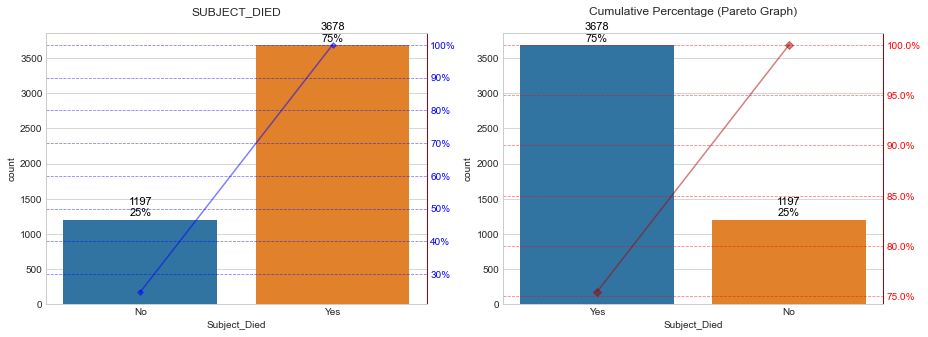

Column: Death_Days  (DataType: float64)
N         = 3432 [Non-NaN: 3432]
Missingness: 1443 (29.6%)
Min       = 0.00  
Max       = 2033.00  
SE / Std  = 198.93  (Standard Error or Std.Dev.)
SEM       = 3.40  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 198.93/sqrt(3432)] 
Mean      = 306.29 +/- 198.93 (Std.Dev.) [Precision of the Mean = 306.29 +/- 3.40 (SEM)] 
Median    = 289.00  
Mode      = 218.0
Variance  = 39571.76 (Coefficient of Variation = 0.65)
Skewness  = 1.62 (Right-Skewed) (Highly Skewed) 
Kurtosis  = 7.05 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 160.75]   [Q2: 50% < 289.00]   [Q3: 75% < 416.25]
 -IQR     = 255.500 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 799.500]


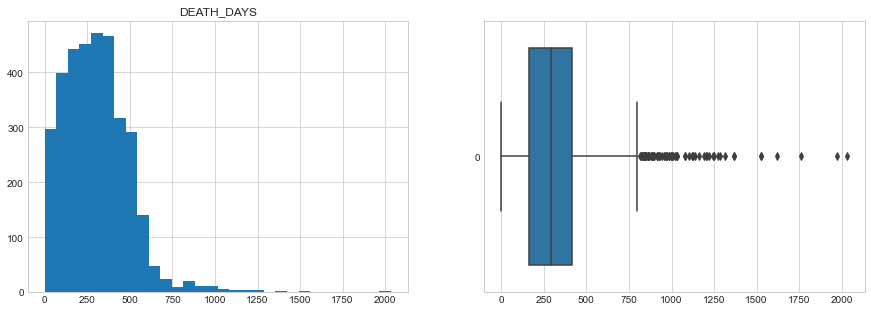

In [26]:
utils.plot_histogram_and_boxplot(df=df_raw, column='Subject_Died')
utils.plot_histogram_and_boxplot(df=df_raw, column='Death_Days')

### Join the 2 datasets (renaming some columns)

In [27]:
df = utils.join_datasets_by_key(df_main=df_main, df_to_join=df_raw, key_name='subject_id', how='left', 
                                raise_error=True)

# rename columns
df.rename(
    columns={
        "Subject_Died": "Event_Dead", 
        "Death_Days": "Event_Dead_Delta"
    }, 
    inplace=True
)

print(utils.get_quantity_of_rows(df_main))
print(utils.get_quantity_of_rows(df_raw))
print(utils.get_quantity_of_rows(df))

df

5230
4875
5230


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,Slow,0.0,34.0,0-39,0.0,287.0,1993.0,65,NaN,NaN
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,Rapid,2.0,51.0,50-59,2.0,401.0,902.0,29,NaN,NaN
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,Slow,0.0,63.0,60-69,3.0,404.0,1427.0,46,NaN,NaN
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,Rapid,2.0,61.0,60-69,3.0,3.0,718.0,23,NaN,NaN
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,Rapid,2.0,43.0,40-49,1.0,250.0,1320.0,43,Yes,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,Average,1.0,62.0,60-69,3.0,119.0,545.0,17,NaN,NaN
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,Average,1.0,66.0,60-69,3.0,127.0,778.0,25,NaN,NaN
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,Average,1.0,57.0,50-59,2.0,127.0,965.0,31,NaN,NaN
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,Rapid,2.0,49.0,40-49,1.0,125.0,280.0,9,NaN,NaN


---
---
---
## Convert `event_dead` column to `Boolean` datatype, converting `NaN` values to False (not dead)

In [28]:
df.groupby('Event_Dead', dropna=False).count()

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead_Delta
Event_Dead,,,,,,,,,,,,,,,,,,,,,
No,1171,1171,1171,1171,1171,1171,1171,1171,1171,1171,...,1171,1171,1171,1171,1171,1171,1171,1171,1171,0
Yes,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,...,1250,1250,1250,1250,1250,1250,1250,1250,1250,1084
NaN,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,...,2809,2809,2809,2809,2809,2809,2809,2809,2809,0


In [29]:
df.Event_Dead = df.Event_Dead.map(
    {
        'Yes'  : True,
        'No'   : False, 
         np.NaN: False,
    }
)

df

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,Slow,0.0,34.0,0-39,0.0,287.0,1993.0,65,False,NaN
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,Rapid,2.0,51.0,50-59,2.0,401.0,902.0,29,False,NaN
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,Slow,0.0,63.0,60-69,3.0,404.0,1427.0,46,False,NaN
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,Rapid,2.0,61.0,60-69,3.0,3.0,718.0,23,False,NaN
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,Rapid,2.0,43.0,40-49,1.0,250.0,1320.0,43,True,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,Average,1.0,62.0,60-69,3.0,119.0,545.0,17,False,NaN
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,Average,1.0,66.0,60-69,3.0,127.0,778.0,25,False,NaN
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,Average,1.0,57.0,50-59,2.0,127.0,965.0,31,False,NaN
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,Rapid,2.0,49.0,40-49,1.0,125.0,280.0,9,False,NaN


### Create column `Event_Dead_Delta_from_Onset_in_days` with 
### the `Last_Visit_Delta_from_Onset_in_days` column for those samples with `Event_Dead` = `False` (not died)


In [30]:
df_event_dead_false = df.loc[(df.Event_Dead==False)].copy()

df_event_dead_false['Event_Dead_Time_from_Onset_in_days'] = df_event_dead_false['Last_Visit_from_Onset_in_Days']
df_event_dead_false['Event_Dead_Time_from_Onset'] = df_event_dead_false['Last_Visit_from_Onset']


df.loc[df_event_dead_false.index,
      'Event_Dead_Time_from_Onset_in_days'] = df_event_dead_false['Event_Dead_Time_from_Onset_in_days']

df.loc[df_event_dead_false.index,
      'Event_Dead_Time_from_Onset'] = df_event_dead_false['Event_Dead_Time_from_Onset']

df


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta,Event_Dead_Time_from_Onset_in_days,Event_Dead_Time_from_Onset
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,34.0,0-39,0.0,287.0,1993.0,65,False,NaN,1993.0,65.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,51.0,50-59,2.0,401.0,902.0,29,False,NaN,902.0,29.0
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,63.0,60-69,3.0,404.0,1427.0,46,False,NaN,1427.0,46.0
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,61.0,60-69,3.0,3.0,718.0,23,False,NaN,718.0,23.0
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,43.0,40-49,1.0,250.0,1320.0,43,True,250.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,62.0,60-69,3.0,119.0,545.0,17,False,NaN,545.0,17.0
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,66.0,60-69,3.0,127.0,778.0,25,False,NaN,778.0,25.0
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,57.0,50-59,2.0,127.0,965.0,31,False,NaN,965.0,31.0
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,49.0,40-49,1.0,125.0,280.0,9,False,NaN,280.0,9.0


Check if exist NaN-values (must show `[False  True]`)

In [31]:
#check if exist NaN-values (must show [False  True])
print(df.Event_Dead_Time_from_Onset.isna().unique()) 


[False  True]


### Create column `Event_Dead_Delta_from_Onset_in_days` with 
### the `Last_Visit_Delta_from_Onset_in_days` column for those samples with `Event_Dead` = `True` (died)
### and  `Event_Dead_Delta` = NaN


In [32]:
df_event_dead_true = df.loc[
    (df.Event_Dead==True)
   &(df.Event_Dead_Delta.isnull() )
].copy()

display(df_event_dead_true)

df.loc[df_event_dead_true.index,
      'Event_Dead_Time_from_Onset_in_days'] = df['Last_Visit_from_Onset_in_Days']

df.loc[df_event_dead_true.index,
      'Event_Dead_Time_from_Onset'] = df['Last_Visit_from_Onset']

df.loc[df_event_dead_true.index]


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta,Event_Dead_Time_from_Onset_in_days,Event_Dead_Time_from_Onset
16,4205,Male,5.0,5.0,0.0,0.0,20.0,0.0,0.0,30.0,...,38.0,0-39,0.0,547.0,1096.0,36,True,NaN,NaN,NaN
17,4429,Male,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,56.0,50-59,2.0,347.0,687.0,22,True,NaN,NaN,NaN
23,5148,Male,2.0,2.0,0.0,0.0,8.0,0.0,0.0,12.0,...,65.0,60-69,3.0,90.0,458.0,15,True,NaN,NaN,NaN
27,5806,Female,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,69.0,60-69,3.0,364.0,987.0,32,True,NaN,NaN,NaN
95,16265,Female,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,63.0,60-69,3.0,358.0,770.0,25,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566,960114,Female,3.0,3.0,0.0,0.0,12.0,0.0,0.0,18.0,...,62.0,60-69,3.0,208.0,591.0,19,True,NaN,NaN,NaN
4650,975460,Male,1.0,1.0,0.0,0.0,4.0,0.0,0.0,6.0,...,78.0,70+,4.0,0.0,188.0,6,True,NaN,NaN,NaN
4737,993802,Male,5.0,5.0,0.0,0.0,20.0,0.0,0.0,30.0,...,53.0,50-59,2.0,539.0,1281.0,42,True,NaN,NaN,NaN
4765,999117,Male,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,54.0,50-59,2.0,546.0,1083.0,35,True,NaN,NaN,NaN


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta,Event_Dead_Time_from_Onset_in_days,Event_Dead_Time_from_Onset
16,4205,Male,5.0,5.0,0.0,0.0,20.0,0.0,0.0,30.0,...,38.0,0-39,0.0,547.0,1096.0,36,True,NaN,1096.0,36.0
17,4429,Male,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,56.0,50-59,2.0,347.0,687.0,22,True,NaN,687.0,22.0
23,5148,Male,2.0,2.0,0.0,0.0,8.0,0.0,0.0,12.0,...,65.0,60-69,3.0,90.0,458.0,15,True,NaN,458.0,15.0
27,5806,Female,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,69.0,60-69,3.0,364.0,987.0,32,True,NaN,987.0,32.0
95,16265,Female,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,63.0,60-69,3.0,358.0,770.0,25,True,NaN,770.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566,960114,Female,3.0,3.0,0.0,0.0,12.0,0.0,0.0,18.0,...,62.0,60-69,3.0,208.0,591.0,19,True,NaN,591.0,19.0
4650,975460,Male,1.0,1.0,0.0,0.0,4.0,0.0,0.0,6.0,...,78.0,70+,4.0,0.0,188.0,6,True,NaN,188.0,6.0
4737,993802,Male,5.0,5.0,0.0,0.0,20.0,0.0,0.0,30.0,...,53.0,50-59,2.0,539.0,1281.0,42,True,NaN,1281.0,42.0
4765,999117,Male,4.0,4.0,0.0,0.0,16.0,0.0,0.0,24.0,...,54.0,50-59,2.0,546.0,1083.0,35,True,NaN,1083.0,35.0


### Calculate column `Event_Dead_Time_from_Onset`  (months) for those samples 
### with `Event_Dead` = `True` (died) and  `Event_Dead_Delta` <> NaN


In [33]:
df_to_update = df.loc[
    (df.Event_Dead==True)
   &(df.Event_Dead_Delta.isnull()==False )
].copy()


df.loc[df_to_update.index,
      'Event_Dead_Time_from_Onset_in_days'] = df['Event_Dead_Delta'] + np.abs(df.Symptoms_Onset_Delta)

#calculate in MONTHS
in_months = df['Event_Dead_Time_from_Onset_in_days'].apply( lambda x: utils.calculate_months_from_days(x)) 

df.loc[df_to_update.index,
      'Event_Dead_Time_from_Onset'] = in_months


df.loc[df_to_update.index]



,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Last_Visit_Delta,Last_Visit_from_Onset_in_Days,Last_Visit_from_Onset,Event_Dead,Event_Dead_Delta,Event_Dead_Time_from_Onset_in_days,Event_Dead_Time_from_Onset
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,43.0,40-49,1.0,250.0,1320.0,43,True,250.0,1320.0,43.0
15,3981,Male,5.0,6.0,4.0,0.0,150.0,0.0,0.0,165.0,...,62.0,60-69,3.0,82.0,292.0,9,True,82.0,292.0,9.0
31,7036,Female,8.0,8.0,9.0,0.0,264.0,0.0,0.0,289.0,...,64.0,60-69,3.0,303.0,706.0,23,True,303.0,706.0,23.0
38,8258,Female,11.0,10.0,6.0,0.0,180.0,16.0,205.0,428.0,...,67.0,60-69,3.0,587.0,1498.0,49,True,587.0,1498.0,49.0
45,10059,Female,7.0,5.0,8.0,0.0,160.0,0.0,0.0,180.0,...,69.0,60-69,3.0,194.0,483.0,15,True,194.0,483.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5169,419920,Male,14.0,0.0,0.0,11.0,386.0,15.0,144.0,570.0,...,38.0,0-39,0.0,388.0,691.0,22,True,388.0,691.0,22.0
5184,854140,Male,10.0,0.0,0.0,10.0,385.0,16.0,128.0,549.0,...,55.0,50-59,2.0,288.0,618.0,20,True,288.0,618.0,20.0
5192,548635,Male,10.0,0.0,0.0,10.0,388.0,16.0,128.0,552.0,...,62.0,60-69,3.0,259.0,833.0,27,True,259.0,833.0,27.0
5205,891359,Female,13.0,0.0,0.0,13.0,465.0,22.0,176.0,689.0,...,58.0,50-59,2.0,394.0,1375.0,45,True,394.0,1375.0,45.0


### Show total of samples non-NaN (and NaN) for each column

In [34]:
utils.show_columns_stats(df)

subject_id........................ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex............................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS........... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS....... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC.............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC.............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements.................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta..........

----
----
----
# Delete unncessary columns 

In [35]:
to_delete = [
    'Event_Dead_Delta',
    'Last_Visit_Delta',
    'Last_Visit_from_Onset',
    'Last_Visit_from_Onset_in_Days',
    'Event_Dead_Time_from_Onset_in_days',
]


df.drop(
    columns=to_delete, 
    inplace=True,
)


In [36]:
utils.show_columns_stats(df=df)

subject_id....................... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5230 
Sex.............................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Qty_Measurements_ALSFRS.......... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    32 
Qty_Measurements_VITALSIGNS...... =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    55 
Qty_Measurements_FVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    20 
Qty_Measurements_SVC............. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    17 
Qty_Measurements_LABS............ =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   953 
Qty_Measurements_HANDGRIPSTRENGTH =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=    38 
Qty_Measurements_MUSCLESTRENGTH.. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=   293 
Qty_Measurements................. =  5230 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1087 
Symptoms_Onset_Delta............. =  523

----
----
----
# Group patients into Survival group ranges:
	- Short     <=24   Code: 2
	- Average  25-60   Code: 1
	- Long      >=61   Code: 0

In [37]:
to_update = df.loc[
    (df.Event_Dead==True)
   &(df.Event_Dead_Time_from_Onset<=24)
].copy()
df.loc[to_update.index, 'Group_Survival'] = 'Short'
df.loc[to_update.index, 'Group_Survival_Coded'] = 2


to_update = df.loc[
    (df.Event_Dead==True)
   &(df.Event_Dead_Time_from_Onset>=25)
   &(df.Event_Dead_Time_from_Onset<=60)
].copy()
df.loc[to_update.index, 'Group_Survival'] = 'Average'
df.loc[to_update.index, 'Group_Survival_Coded'] = 1


to_update = df.loc[
    (df.Event_Dead_Time_from_Onset>60)
].copy()
df.loc[to_update.index, 'Group_Survival'] = 'Long'
df.loc[to_update.index, 'Group_Survival_Coded'] = 0

df

,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay,Diagnosis_Delay_Str,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,21.0,Slow,0.0,34.0,0-39,0.0,False,65.0,Long,0.0
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,6.0,Rapid,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,32.0,Slow,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,6.0,Rapid,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,Rapid,2.0,43.0,40-49,1.0,True,43.0,Average,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,22564,Male,7.0,0.0,0.0,7.0,376.0,14.0,201.0,605.0,...,11.0,Average,1.0,62.0,60-69,3.0,False,17.0,NaN,NaN
5226,160135,Female,7.0,0.0,0.0,6.0,365.0,14.0,189.0,581.0,...,17.0,Average,1.0,66.0,60-69,3.0,False,25.0,NaN,NaN
5227,304192,Female,7.0,0.0,0.0,7.0,365.0,14.0,168.0,561.0,...,16.0,Average,1.0,57.0,50-59,2.0,False,31.0,NaN,NaN
5228,820199,Male,7.0,0.0,0.0,7.0,363.0,14.0,173.0,564.0,...,4.0,Rapid,2.0,49.0,40-49,1.0,False,9.0,NaN,NaN


Column: Group_Survival  (DataType: object)
N         = 1414 [Non-NaN: 1414]
Missingness: 3816 (72.96%)

Summary Table:
         count percentage
Average    701     49.58%
Short      516     36.49%
Long       197     13.93%


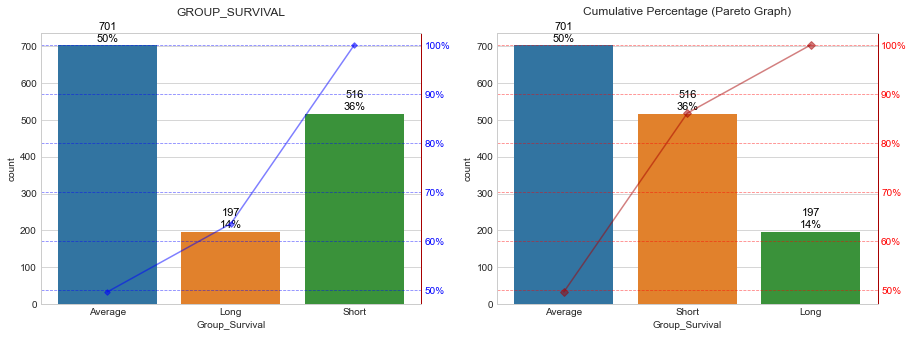

In [41]:
utils.plot_variable_distribution(series=df.Group_Survival)

----
----
----
# Save the pre-processed data to CSV file

In [42]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')
csv_dest = f'{dir_dest}/_patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)



5230 samples were saved


### ######################################################################################
### ######################################################################################
### ######################################################################################


In [ ]:
df